In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib

from IPython.display import display, clear_output
from PIL import Image, ImageFilter, ImageFont, ImageDraw

In [0]:
# define an image size (128, 256, 512)
# the bigger the image size the longer it will take
imsize = 256
tranform_img = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])
unload_img = transforms.ToPILImage()
# func to resize image and turn it into a tensor
def image_loader(address):
    image = Image.open(address)
    image = tranform_img(image)
    image = image[None]
    image = Variable(image)
    return image.to(torch.float)
# tensor -> img
def show_img(tensor):
    image = tensor.clone()
    image = image.detach().cpu()
    image = image.squeeze(0)
    image = unload_img(image)
    image = image.resize((imsize * 2, imsize * 2))
    plt.imshow(image)

# same as the show_img function but we also clear the cell output
plt.ion()
def animate_output(tensor):
    image = tensor.clone()
    image = image.cpu()
    image = image.squeeze(0)
    image = unload_img(image)
    clear_output(wait=True)
    display(image)

In [0]:
# lets define the loss between our content image and a random input
def calc_loss(input_features, target_features, weight):
    return F.mse_loss(input_features, target_features)*weight

In [4]:
# Use the CPU if no GPU is found
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Download the pre-trained vgg model
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [5]:
vgg19

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
device

device(type='cuda')

In [0]:
# Create class that will save the output of the previous layer
class SaveFeatures():
    features = None
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_to_save_features)
    def hook_to_save_features(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

# Register a hook after each Conv layer
saved_feature_layers = []
for i, layer in enumerate(vgg19.children()):
    if (isinstance(layer, nn.Conv2d)): 
        saved_feature_layers.append(SaveFeatures(vgg19[i]))

In [8]:
# Load content image (John Snow)
content_img = image_loader("sample_data/snow_150x150.jpg").to(device)
print(type(content_img))
# Put the content image through the network and save the features from the forward hook
vgg19(content_img)
content_fts_arr = [Variable(sf.features.clone()) for sf in saved_feature_layers]

FileNotFoundError: ignored

In [0]:
# load stye image
style_img = image_loader("sample_data/walker_150x150.jpg").to(device)

# put the style image through the network and save the features from the forward hook
vgg19(style_img)
style_fts_arr = [Variable(sf.features.clone()) for sf in saved_feature_layers]

# for the style loss we need another function to calc the gram of the input
# this will throw away the spacial info from the input but not the features
def to_gram(input):
    b, c, h, w = input.size()
    features = input.view(b*c, h*w)
    mm_features = torch.mm(features, features.t())
    return mm_features/input.numel()

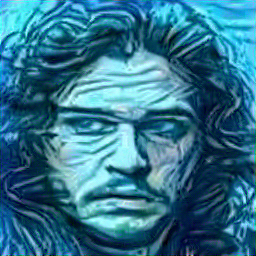

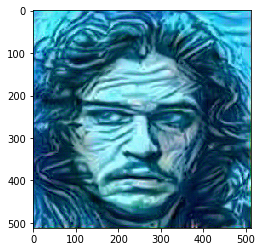

In [0]:
# Load input image (John Snow)
input_img = Variable(image_loader("sample_data/snow_150x150.jpg").to(device), requires_grad=True).to(torch.float)
# Fire up the optimiser!
epochs = 80
num = 0
optimizer = optim.LBFGS([input_img], lr=1)
while num <= epochs:
    def closure():
        global num
        input_img.data.clamp_(0, 1)
        print(f"Num: {num}")
        optimizer.zero_grad()
        # put the Input image through the network
        vgg19(input_img)
        # save the outputs from the network for the input image
        input_fts_arr = [layer.features for layer in saved_feature_layers]
        #style loss from the 2nd -> 7th Layers
        style_loss = sum([calc_loss(to_gram(i_fts), to_gram(s_fts), 10000000000) 
                            for i_fts, s_fts in zip(input_fts_arr[1:6], 
                                                    style_fts_arr[1:6])])
        # send the content and input features from Layer 3 to the loss function
        content_loss = sum([calc_loss(i_fts, c_fts, 1000) 
                              for i_fts, c_fts in zip(input_fts_arr[2], 
                                                      content_fts_arr[2])])
        # combine both losses
        loss = style_loss + content_loss
        # Update the input image
        loss.backward()
        print(loss)
        animate_output(input_img)
        num += 1
        return loss
    optimizer.step(closure)
input_img.data.clamp_(0, 1)
show_img(input_img)